In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sympy.solvers import solve
from sympy import Symbol

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
#DADOS FORNECIDOS

nt=0.92 #relação de pressões dinâmicas
st=6.48 #area empenagem
sw=27.3 #area asa
b=16.25 #evergadura
arw=9.67 
art=5.25 
lambdaw=0.4 #afilamento asa
lambdat=0.6 #afilamento empenagem
delta_c4=0
aw=4.9 # rad
at=4.9 # rad
iw=1*(3.14/180) #incidencia asa
alphaLow=-2*(3.14/180)
alphaLot=0
xw=0.407
zw=0
xt=6.71
zt=2.68
Cmw=-0.02 #
Cmt=0

Cmdelta=-0.0071 #graus
Cldelta=0.015 #graus

ss = st/sw #razão entre áreas

In [0]:
#PARÂMETROS DEDUZIDOS (dados gerais)

cr=(sw*2)/(b*(1+lambdaw)) #corda raiz
ct=lambdaw*cr #corda ponta
cbarra = (2/3)*cr*((1+lambdaw+lambdaw**2)/(1+lambdaw)) #mac

kh = (1-abs((zt-zw)/b))/(2*(xt-xw)/b)**(1/3)
kdelta=(10-3*lambdaw)/7
kar=1/arw-1/(1+arw**1.7)

clow = -aw*alphaLow
clot = -at*alphaLot

dev=4.44*(kh*kdelta*kar)**1.19 ## dev = (1-dE/dAlpha)
E0 = -dev*(alphaLow-iw)

cl_alpha = aw+nt*ss*at*(1-dev) 
dcmf_dal=0.25*cl_alpha


**Exercício 2**


In [4]:
#----------a)--------------- 
xn = (aw*xw+at*(1-dev)*ss*nt*xt-dcmf_dal*cbarra)/cl_alpha 
print(f'Xn: {round(xn,5)} [m]');

Xn: 0.82989 [m]


In [5]:
#----------b)--------------- 

it_b =2*(3.14/180) #valor dado
alpha_b = 5*(3.14/180) #valor dado
E_b = E0 + dev*alpha_b

Clo_b = clow+aw*iw+nt*ss*clot+nt*ss*at*(it_b-E0)
Cl_b = Clo_b+cl_alpha*alpha_b

print(f'CL: {round(Cl_b,5)}');


CL: 0.77446


In [6]:
#----------c)---------------

cmfus_b = -0.015+0.25*Cl_b
xcp = ((clow+aw*(alpha_b+iw))*xw+(clot+at*(alpha_b+it_b-E_b))*ss*nt*xt-(Cmw+cmfus_b)*cbarra)/Cl_b

print(f'Xcp: {round(xcp,5)} [m]');

Xcp: 0.77949 [m]


In [7]:
#----------d)--------------- 

xcg = (-0.25+0.33)*cbarra+xw
vh = ((xt-xcg)*ss)/cbarra 
cm_alpha = aw*(xcg-xw)/cbarra - at*(1-dev)*vh*nt
ms = -(xcg-xn)/cbarra

print(f'MS: {round(ms,5)}')

MS: 0.1572


In [8]:
#----------e)--------------- 

cl_trim = 0.43

data = pd.DataFrame(index=np.arange(0,1500),
                    columns=['alpha','it','cmcg']) 

d_alpha = np.linspace(-7,7,1500) 
r_alpha = 0.01745*d_alpha 
loc=np.arange(0,1500) 

for ialpha,iloc in zip(r_alpha,loc):
   
    itt = (cl_trim-clow-aw*iw-nt*ss*clot+nt*ss*at*E0-
           cl_alpha*ialpha)/(nt*ss*at) 
    
    Clo_fus= clow+aw*iw+nt*ss*clot+nt*ss*at*(itt-E0)
    Cl_fus = Clo_fus+cl_alpha*ialpha   
    Cm_fus = -0.015 + 0.25*Cl_fus
    
    
    cmcg = ((clow+aw*iw)*(xcg-xw))/cbarra-(clot+
           at*(itt-E0))*vh*nt+cm_alpha*ialpha + Cmw + Cm_fus 
    
    row = {'alpha': ialpha, 'it': itt, 'cmcg':cmcg} 
    data.iloc[iloc] = row 
    
ind = data['cmcg'].sub(0).abs().values.argmin() 
linha= data.loc[[ind]]

it_trim = float(data.iloc[[ind],1]) 
it_degree = 57.2958*it_trim

print(f'it_trim: {round(it_degree,6)} [º]');


it_trim: 1.195216 [º]


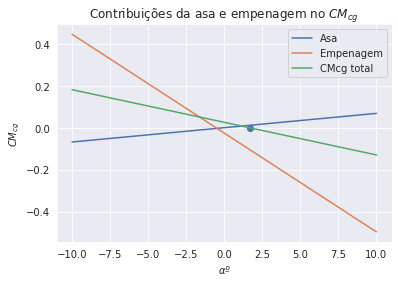

In [9]:
#----------f)--------------- 

alpha_deg = np.linspace(-10,10,1000)
alpha_rad= alpha_deg*0.01745

cm_asa=[]
cm_emp=[]
cm_fus=[]

for al in alpha_rad:
   
    cmasa =((clow+aw*iw+aw*al)*(xcg-xw))/cbarra + Cmw ## contribuição da asa
    cm_asa.append(cmasa)

    cmemp = -(clot+at*(al+it_trim-E0-dev*al))*vh*nt ## contribuição da empenagem
    cm_emp.append(cmemp)
    
    cl_fus= clow+aw*iw+nt*ss*clot+nt*ss*at*(it_trim-E0) + cl_alpha*al
    cm_fuse = -0.015 + 0.25*(cl_fus) ## contribuição da fuselagem
    cm_fus.append(cm_fuse)
      
cm_total=[x+y+z for x,y,z in zip(cm_asa,cm_emp,cm_fus)]

fig=plt.figure()
sns.set_style("darkgrid")
sns.set_palette("deep")
plt.plot(alpha_deg,cm_asa,label='Asa')
plt.scatter(1.67436,-0.000480928)
plt.plot(alpha_deg,cm_emp,label='Empenagem')
plt.plot(alpha_deg,cm_total,label='CMcg total')
plt.legend(loc='best')
plt.xlabel("$\\alpha º$")
plt.ylabel("$CM_{cg}$")
plt.title('Contribuições da asa e empenagem no $CM_{cg}$')
plt.grid(True)

In [10]:
print('----------------#2--------------')
print(f'a) Xn: {round(xn,5)} [m]');
print(f'b) CL: {round(Cl_b,5)}');
print(f'c) Xcp: {round(xcp,5)} [m]');
print(f'd) MS: {round(ms,5)}')
print(f'e) it_trim: {round(it_degree,6)} [º]');

----------------#2--------------
a) Xn: 0.82989 [m]
b) CL: 0.77446
c) Xcp: 0.77949 [m]
d) MS: 0.1572
e) it_trim: 1.195216 [º]


**Exercício 3**

In [11]:
#----------a)--------------- 
CL_trim= 0.6
it3 = 0

data3 = pd.DataFrame(index=np.arange(0,1500),
                     columns=['alpha','delta_e','cmcg'])

for ialpha,iloc in zip(r_alpha,loc):
    
    delta_e= (CL_trim-clow-aw*iw-nt*ss*clot-
              nt*ss*at*(it3-E0)-cl_alpha*ialpha)/(Cldelta)
         
    Cm_fus3 = -0.015 + 0.25*CL_trim
    
    cmcg_e = ((clow+aw*iw)*(xcg-xw))/cbarra - (clot
             +at*(it3-E0))*vh*nt + (Cmw + 
                 Cm_fus3 + cm_alpha*ialpha + Cmdelta*delta_e)
    
    row3 = {'alpha': ialpha, 'delta_e': delta_e, 'cmcg':cmcg_e}
    data3.iloc[iloc] = row3
    
ind3 = data3['cmcg'].sub(0).abs().values.argmin()
linha3= data3.loc[[ind3]]
deltae_trim = float(data3.iloc[[ind3],1])

print(f'delta_trim: {round(deltae_trim,5)} [º]');

delta_trim: 41.71949 [º]


In [12]:
#----------c)--------------- 

cltrim_e=1.7

xcg_list=[]
for delta_e in np.arange(-25,25,0.5): ## mínima e máxima deflexão
    alpha_e = (cltrim_e-clow-aw*iw-nt*ss*clot-ss*
               at*(0-E0)-Cldelta*delta_e)/cl_alpha
    cmfus_e = -0.015+0.25*cltrim_e
    Ee = E0 + dev*alpha_e
    xcgg = Symbol('xcgg')

    cmcg = (clow+aw*(iw+alpha_e))*(xcgg-xw)/cbarra+(Cmw+
           cmfus_e-(clot+at*(alpha_e-Ee))*(xt-
                   xcgg)*ss*nt/cbarra + Cmdelta*delta_e)

    xcg_list.append(solve(cmcg,xcgg))
    
xcg_min = min(xcg_list)
xcg_min=xcg_min[0]

print(f'Passeio CG: {round(xcg_min,5)}  < xcg < {round(xn,5)} [m]');

Passeio CG: 0.64175  < xcg < 0.82989 [m]


In [13]:
print('----------------#3--------------')    
print(f'a) delta_trim: {round(deltae_trim,5)} [º]');
print(f'b) Xn: {round(xn,5)} [m]');
print(f'c) Passeio CG: {round(xcg_min,5)}  < xcg < {round(xn,5)} [m]');

----------------#3--------------
a) delta_trim: 41.71949 [º]
b) Xn: 0.82989 [m]
c) Passeio CG: 0.64175  < xcg < 0.82989 [m]
